In [0]:
!pip install git+https://github.com/VowpalWabbit/vowpal_wabbit.git#egg=vowpalwabbit


  Cloning https://github.com/VowpalWabbit/vowpal_wabbit.git to /tmp/pip-install-rccyprls/vowpalwabbit
  Running command git clone -q https://github.com/VowpalWabbit/vowpal_wabbit.git /tmp/pip-install-rccyprls/vowpalwabbit
  Running command git submodule update --init --recursive -q
  Created wheel for vowpalwabbit: filename=vowpalwabbit-8.8.0-cp36-cp36m-linux_x86_64.whl size=1729114 sha256=a1aada435cf029e536a26e85260d4d88448a0ebba5814c866e14e337be0d5c25
  Stored in directory: /tmp/pip-ephem-wheel-cache-23b1p0ce/wheels/a7/f6/7b/444396d70448679da7b0a8bbb068ea3b79d4b2aba9e5fae418
Successfully built vowpalwabbit


In [0]:
import matplotlib.pyplot as plt


In [0]:
import pandas as pd
import sklearn as sk
from vowpalwabbit import pyvw
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import re
import random

In [0]:
!wget https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv

--2020-02-26 16:17:26--  https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3975 (3.9K) [text/plain]
Saving to: ‘iris.csv’

iris.csv            100%[===================>]   3.88K  --.-KB/s    in 0s      

2020-02-26 16:17:26 (73.0 MB/s) - ‘iris.csv’ saved [3975/3975]



In [0]:
df = pd.read_csv('iris.csv')

In [0]:
df.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [0]:
df = df.rename(columns={"sepal.length": "SepalLength", "sepal.width": "SepalWidth", "petal.length": "PetalLength", "petal.width": "PetalWidth"})

In [0]:
tags = pd.unique(df['variety'])
tags

array(['Setosa', 'Versicolor', 'Virginica'], dtype=object)

In [0]:
df['tags'] = df['variety'].map({tags[0]: 0, tags[1]: 1, tags[2]: 2})

In [0]:
CORRECT_TAG = 0.0
INCORRECT_TAG = -1.0

def get_cost(context, index, df, action):
    correct_tag = df.variety[index]
    if(action == correct_tag):
        return CORRECT_TAG
    else:
        return INCORRECT_TAG

In [0]:
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    for action in actions:
        if cb_label is not None and action == chosen_action:
            # Overwriting the probability of taking some action to 1
            # as in this dataset, we are not given probablities of actions
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action flower={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [0]:
# To return the action with max confidence score
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

In [0]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [0]:
actions = pd.unique(df['variety']) # ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

def run_simulation(vw, num_iterations, actions, df, do_learn = True):
    cost_sum = 0.
    ctr = []

    for i in range(1, num_iterations+1):
        i = i%148 + 1
        # 3. Pass context to vw to get an action
        context = {'SepalLength': df.SepalLength[i], 'SepalWidth': df.SepalWidth[i], \
                  'PetalLength': df.PetalLength[i], 'PetalWidth': df.PetalWidth[i]}
        action, prob = get_action(vw, context, actions)
        # 4. Get cost of the action we chose
        cost = get_cost(context, i, df, action)
        cost_sum += cost

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            # print(to_vw_example_format(context, actions, (action, cost, prob)))
            vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
            # 6. Learn
            vw.learn(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1*cost_sum/i)

    return ctr

In [0]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

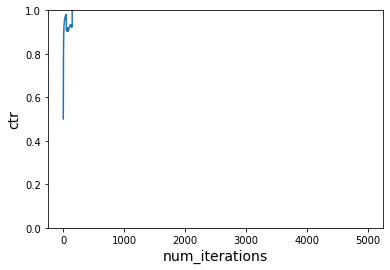

In [0]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, actions, df)

plot_ctr(num_iterations, ctr)